In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torchvision.transforms import ToTensor
from lightning_module import LitPromptIR

def show_grid(ckpt, root='data/test/degraded', n=9, device='cuda'):
    model = LitPromptIR.load_from_checkpoint(ckpt, map_location=device)
    model.eval().to(device)
    t = ToTensor()

    sel = np.random.choice(list(Path(root).glob('*.png')), n, False)
    s = int(np.sqrt(n))
    fig, ax = plt.subplots(s, s, figsize=(8,8))
    with torch.no_grad():
        for a, p in zip(ax.flatten(), sel):
            x = t(Image.open(p).convert('RGB')).unsqueeze(0).to(device)
            y = model(x).clamp(0,1).cpu().squeeze()
            a.imshow(y.permute(1,2,0).numpy())
            a.set_title(p.name, fontsize=8)
            a.axis('off')
    plt.tight_layout()


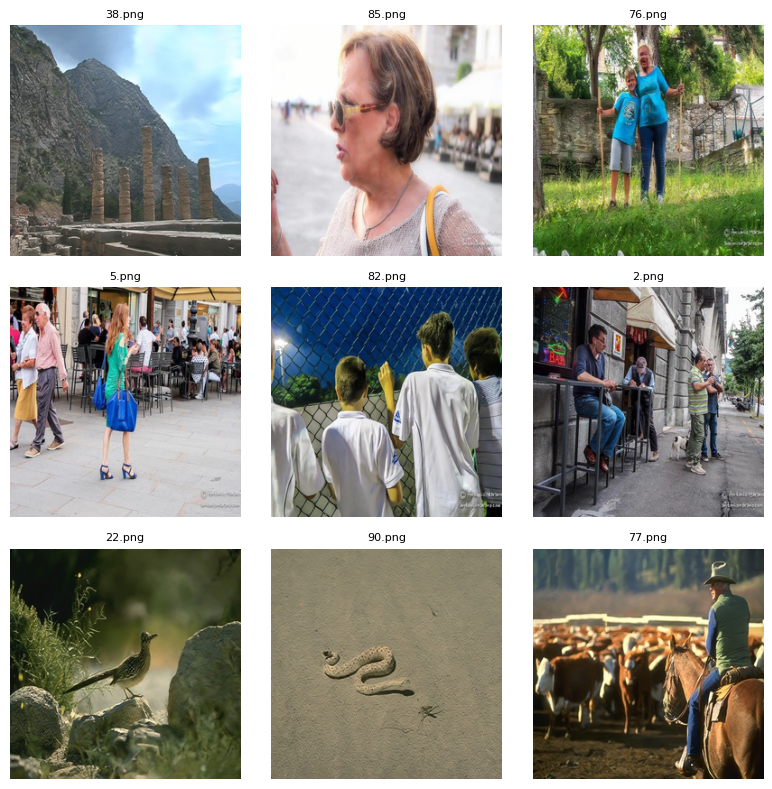

In [6]:
show_grid("ckpts/promptirnewssim-epoch=187-val_PSNR=0.00.ckpt")

In [18]:
from datasets_hw4 import get_train_val_loaders

def tensor2np(img):
    """(C,H,W) ∈[0,1]  →  (H,W,C) uint8"""
    return (img.detach().cpu().permute(1, 2, 0).clamp(0, 1).numpy() * 255).astype("uint8")


def visualize_val_grid(
    ckpt="ckpts/promptirnewssim-epoch=187-val_PSNR=0.00.ckpt",
    data_root="data",
    rows: int = 3,
    patch: int = 256,
    device: str = "cuda",
):
    # ↓ 只要 val loader
    _, val_loader = get_train_val_loaders(data_root, batch=1, num_workers=0, patch=patch)

    model = LitPromptIR.load_from_checkpoint(ckpt, map_location=device)
    model.eval().to(device)

    # (rows × 3) 網格：Input | Output | GT
    fig, axes = plt.subplots(rows, 3, figsize=(9, 3 * rows))
    if rows == 1:
        axes = axes[None, :]           # 保證 2-D 索引

    with torch.no_grad():
        for r, batch in enumerate(val_loader):
            if r >= rows:
                break

            x = batch["degraded"].to(device)
            y_pred = model(x).clamp(0, 1)
            y_gt   = batch["clean"]

            # 畫三張
            axes[r, 0].imshow(tensor2np(x[0]))
            axes[r, 0].set_title("Input")
            axes[r, 1].imshow(tensor2np(y_pred[0]))
            axes[r, 1].set_title("Model Output")
            axes[r, 2].imshow(tensor2np(y_gt[0]))
            axes[r, 2].set_title("Ground Truth")

            for c in range(3):
                axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()

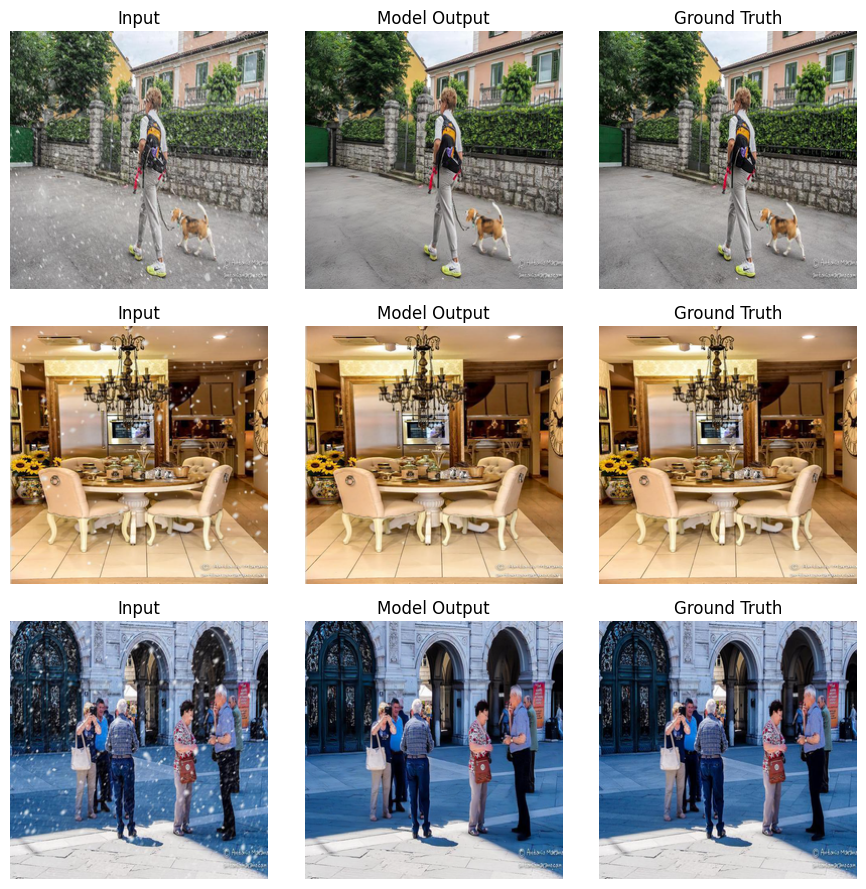

In [20]:
visualize_val_grid("ckpts/promptirnewssim-epoch=187-val_PSNR=0.00.ckpt")